In [14]:
import os
import json
import pandas as pd

# Path to the folder containing the processed data
PROCESSED_DIR = "../data/3_outputs"

# Dictionaries for storing data
processed_frames = {}
processed_logs = {}

# List all files in the folder
all_files = os.listdir(PROCESSED_DIR)
# Filter by JSON files, as these are the “table of contents” for the Parquets.
json_files = sorted([f for f in all_files if f.endswith('.json')])

print(f"Load Data: {PROCESSED_DIR}")
print(f"Found {len(json_files)} city data pairs.\n")

for j_file in json_files:
    # Build paths
    j_path = os.path.join(PROCESSED_DIR, j_file)
    p_path = j_path.replace('.json', '.parquet')
    
    # Load log file (JSON)
    with open(j_path, 'r') as f:
        meta = json.load(f)
    
    city_name = meta['city']
    processed_logs[city_name] = meta
    
    # Loading Parquet file
    if os.path.exists(p_path):
        df = pd.read_parquet(p_path)
        processed_frames[city_name] = df
        
        # Brief status report
        start = meta['time_frame']['start_exact'][:10] # Nur Datum
        end = meta['time_frame']['end_exact'][:10]
        vars_count = meta['variables']['count']
        
        print(f"✅ {city_name:<18} | {len(df):>7} rows | {vars_count} Vars | {start} bis {end}")
    else:
        print(f"⚠️ Warning: Parquet file for {city_name} is missing!")

print(f"\n All data successfully loaded into ‘processed_frames’ and ‘processed_logs’.")

Load Data: ../data/3_outputs
Found 5 city data pairs.

✅ bordeaux           |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31
✅ lyon               |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31
✅ marseille          |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31
✅ marseillemarignane |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31
✅ paris              |  315576 rows | 14 Vars | 1990-01-01 bis 2025-12-31

 All data successfully loaded into ‘processed_frames’ and ‘processed_logs’.


In [15]:
# Optional: Reduce memory consumption by approx. 50%
for city in processed_frames:
    # Convert float64 to float32
    cols = processed_frames[city].select_dtypes(include=['float64']).columns
    processed_frames[city][cols] = processed_frames[city][cols].astype('float32')

In [16]:
example_city = list(processed_frames.keys())[0]
df = processed_frames[example_city]

print("=== INDEX ===")
print(type(df.index))
print(df.index[:5])

print("\n=== COLUMNS ===")
print(df.columns.tolist())

print("\n=== HEAD ===")
print(df.head(3))

print("\n=== DTYPES ===")
print(df.dtypes)

=== INDEX ===
<class 'pandas.core.indexes.range.RangeIndex'>
RangeIndex(start=0, stop=5, step=1)

=== COLUMNS ===
['timestamp', 'temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'shortwave_radiation', 'soil_moisture_0_to_7cm', 'wind_speed_10m', 't_850hPa', 't_500hPa', 'u_850hPa', 'u_500hPa', 'v_850hPa', 'v_500hPa', 'wind_dir_sin', 'wind_dir_cos']

=== HEAD ===
            timestamp  temperature_2m  relative_humidity_2m  pressure_msl  \
0 1990-01-01 00:00:00          4.5865             96.222481   1017.500000   
1 1990-01-01 01:00:00          4.2865             96.892365   1017.000000   
2 1990-01-01 02:00:00          4.1865             97.231163   1016.700012   

   shortwave_radiation  soil_moisture_0_to_7cm  wind_speed_10m    t_850hPa  \
0                  0.0                   0.287        7.172949  277.720581   
1                  0.0                   0.287        6.214563  277.574951   
2                  0.0                   0.287        5.804825  277.428101   

     t_

In [17]:
# -----------------------------------------------------------------------
# FEATURE ENGINEERING — EXPLANATION
# -----------------------------------------------------------------------
#
# 1. Z-SCORE NORMALIZATION (leakage-free)
#    Removes the diurnal cycle and seasonal variation from each variable.
#    For each variable, mean and standard deviation are computed per
#    day-of-year × hour, using only the training period (1990–2015).
#    Result: a value of +2.0 means "2 standard deviations above what is
#    normal for this hour on this day of the year" — independent of
#    season or time of day. Prevents the model from learning trivial
#    patterns like "July is warmer than January".
#
# 2. CYCLICAL TIME ENCODING
#    hour_sin / hour_cos:  encodes the hour of day as a point on a circle,
#                          so that 23:00 and 00:00 are treated as adjacent.
#    doy_sin  / doy_cos:   same principle for day of year, so that
#                          December 31 and January 1 are adjacent.
#    Without cyclical encoding, a linear model would treat midnight and
#    noon as maximally different, which is physically wrong. --> maybe not absolutely necessary
#
# 3. LAG FEATURES
#    lag_t850_72h:   temperature at 850 hPa 72 hours ago.
#                    Large-scale warm air advection builds up over days —
#                    the atmospheric state 3 days ago is a strong predictor
#                    of today's heatwave risk.
#    lag_press_48h:  mean sea level pressure 48 hours ago.
#                    Anticyclonic build-up (rising pressure) typically
#                    precedes heatwaves by 1–2 days.
#    lag_v850_72h:   meridional (north-south) wind at 850 hPa 72h ago.
#                    Southerly flow transports warm air from North Africa —
#                    a key precursor to Western European heatwaves.
#    lag_t500_72h:   temperature at 500 hPa (~5500m) 72 hours ago.
#    lag_t500_48h:   temperature at 500 hPa 48 hours ago.
#                    Upper-level warmth is critical for atmospheric
#                    blocking — without a warm upper atmosphere, surface
#                    heat dissipates quickly and no sustained heatwave forms.
#
# 4. TENDENCY FEATURES
#    delta_press_24h:  pressure change over the last 24 hours.
#                      Rising pressure indicates an approaching anticyclone
#                      (high pressure system) — the synoptic pattern most
#                      associated with European heatwaves.
#                      Falling pressure indicates incoming disturbances
#                      that typically break heatwave conditions.
#    delta_hum_24h:    humidity change over the last 24 hours.
#                      A rapid drying trend signals reduced cloud cover
#                      and increased surface heating — a heatwave amplifier.
#
# 5. HEAT ARIDITY INDEX
#    heat_aridity_index = (t_850hPa in °C) - relative_humidity_2m
#    Combines upper-level warmth with surface dryness in a single value.
#    High values (hot + dry) indicate strong heatwave potential.
#    Low values (cool + humid) suppress heatwave development.
#    t_850hPa is converted from Kelvin to Celsius before subtraction
#    so that the index is physically interpretable on a consistent scale.
#    Example:
#      t_850hPa = 22°C, humidity = 20% → index = +2  (high risk)
#      t_850hPa = 15°C, humidity = 70% → index = -55 (low risk)
#
# 6. SMOOTHED MERIDIONAL WIND (V850)
#    v850_smooth_6h: 6-hour rolling mean of v_850hPa.
#    Reduces hour-to-hour noise in the wind signal.
#    Persistent southerly flow (positive v_850hPa) over several hours
#    is a much stronger heatwave signal than a single-hour spike.
# -----------------------------------------------------------------------

In [18]:
################################################################################
# FEATURE ENGINEERING - TARGETED
# Based on 7 features + Z-score + city + time
# heat_aridity_index corrected in Celsius
################################################################################
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

TRAIN_END = '2015-12-31'
REF_START = '1990-01-01'

ZSCORE_COLS = [
    'temperature_2m', 't_850hPa', 't_500hPa',
    'pressure_msl', 'relative_humidity_2m',
    'soil_moisture_0_to_7cm', 'wind_speed_10m',
    # 'shortwave_radiation' ← removed due to outlier problem (nighttime = 0)
]

def compute_climatology(df: pd.DataFrame, cols: list) -> dict:
    ref = df[REF_START:TRAIN_END]
    clim = {}
    for col in cols:
        if col not in df.columns:
            continue
        grp = ref.groupby([ref.index.dayofyear, ref.index.hour])[col]
        clim[col] = {'mean': grp.mean(), 'std': grp.std()}
    return clim

def apply_zscore(df: pd.DataFrame, clim: dict) -> pd.DataFrame:
    doy  = df.index.dayofyear.values
    hour = df.index.hour.values
    for col, stats in clim.items():
        if col not in df.columns:
            continue
        mean_2d = stats['mean'].unstack(level=1).values
        std_2d  = stats['std'].unstack(level=1).values
        mean_arr = mean_2d[doy - 1, hour]
        std_arr  = std_2d[doy - 1, hour]
        df[f'{col}_zscore'] = (df[col].values - mean_arr) / (std_arr + 1e-8)
    return df

def engineer_features(df: pd.DataFrame, city_name: str) -> tuple:
    df = df.copy()
    
    if 'timestamp' in df.columns:
        df = df.set_index('timestamp')
        df.index = pd.to_datetime(df.index)

    # ------------------------------------------------------------------ #
    # 1. Z-SCORE (leakage-free, only from training period)
    # ------------------------------------------------------------------ #
    clim = compute_climatology(df, ZSCORE_COLS)
    df = apply_zscore(df, clim)

    # ------------------------------------------------------------------ #
    # 2. Temporal context features (cyclical)
    # ------------------------------------------------------------------ #
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['doy_sin']  = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df['doy_cos']  = np.cos(2 * np.pi * df.index.dayofyear / 365)

    # ------------------------------------------------------------------ #
    # 3. LAG FEATURES
    # ------------------------------------------------------------------ #
    if 't_850hPa' in df.columns:
        df['lag_t850_72h']  = df['t_850hPa'].shift(72)
    if 'pressure_msl' in df.columns:
        df['lag_press_48h'] = df['pressure_msl'].shift(48)
    if 'v_850hPa' in df.columns:
        df['lag_v850_72h']  = df['v_850hPa'].shift(72)

    if 't_500hPa' in df.columns:                           # NEU
        df['lag_t500_72h']  = df['t_500hPa'].shift(72)     # NEU
        df['lag_t500_48h']  = df['t_500hPa'].shift(48)     # NEU

    # ------------------------------------------------------------------ #
    # 4. TENDENCY FEATURES
    # ------------------------------------------------------------------ #
    if 'pressure_msl' in df.columns:
        df['delta_press_24h'] = df['pressure_msl'] - df['pressure_msl'].shift(24)
    if 'relative_humidity_2m' in df.columns:
        df['delta_hum_24h']   = df['relative_humidity_2m'] - df['relative_humidity_2m'].shift(24)

    # ------------------------------------------------------------------ #
    # 5. HEAT ARIDITY INDEX (t_850hPa in Celsius)
    # ------------------------------------------------------------------ #
    if 't_850hPa' in df.columns and 'relative_humidity_2m' in df.columns:
        t850_celsius = df['t_850hPa'] - 273.15
        df['heat_aridity_index'] = t850_celsius - df['relative_humidity_2m']

    # ------------------------------------------------------------------ #
    # 6. V850 SMOOTHED
    # ------------------------------------------------------------------ #
    if 'v_850hPa' in df.columns:
        df['v850_smooth_6h'] = df['v_850hPa'].rolling(window=6).mean()

    print(f"  ✅ {city_name}: Features engineered. Shape: {df.shape}")
    return df, clim

################################################################################
# APPLY TO ALL CITIES (parallelized)
################################################################################

def process_city(args):
    city, df = args
    return city, engineer_features(df, city)

engineered_frames = {}
city_climatologies = {}

print("Starting Feature Engineering...\n")
with ThreadPoolExecutor(max_workers=5) as executor:
    results = list(executor.map(process_city, processed_frames.items()))

for city, (df, clim) in results:
    engineered_frames[city] = df
    city_climatologies[city] = clim

print(f"\n✅ Done. {len(engineered_frames)} cities processed.")
print(list(engineered_frames.keys()))

################################################################################
# SANITY CHECK
################################################################################

example_city = list(engineered_frames.keys())[0]
new_cols = [c for c in engineered_frames[example_city].columns 
            if any(x in c for x in ['lag', 'delta', 'aridity', 'smooth', 'zscore', 'sin', 'cos'])]

print(f"\nEngineered Features in '{example_city}' ({len(new_cols)} total):")
print(engineered_frames[example_city][new_cols].describe().round(3))


Starting Feature Engineering...

  ✅ lyon: Features engineered. Shape: (315576, 34)
  ✅ marseillemarignane: Features engineered. Shape: (315576, 34)
  ✅ paris: Features engineered. Shape: (315576, 34)
  ✅ bordeaux: Features engineered. Shape: (315576, 34)
  ✅ marseille: Features engineered. Shape: (315576, 34)

✅ Done. 5 cities processed.
['bordeaux', 'lyon', 'marseille', 'marseillemarignane', 'paris']

Engineered Features in 'bordeaux' (22 total):
       wind_dir_sin  wind_dir_cos  temperature_2m_zscore  t_850hPa_zscore  \
count    315576.000    315576.000             315576.000       315576.000   
mean         -0.111         0.079                  0.048            0.069   
std           0.720         0.680                  1.001            1.010   
min          -1.000        -1.000                 -4.172           -3.268   
25%          -0.846        -0.555                 -0.683           -0.683   
50%          -0.210         0.110                  0.035            0.069   
75%     

In [19]:

################################################################################
# XGBOOST PIPELINE: TRAINING & EVALUATION
# Hourly resolution (no aggregate_daily_features)
# Filtered to summer months (May - September)
# P95 from full year of reference period
# City as one-hot feature
################################################################################

import xgboost as xgb
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, average_precision_score)

################################################################################
# 1. MERGE DATA (all cities)
################################################################################

all_frames = []
for city, df in engineered_frames.items():
    df = df.copy()
    df['city'] = city
    all_frames.append(df)

combined = pd.concat(all_frames).sort_index()

print(f"Combined shape (gesamt): {combined.shape}")
print(f"time period: {combined.index.min()} bis {combined.index.max()}")

################################################################################
# 2. DEFINE TARGET (hourly, Klement Event)
################################################################################

def label_heatwave_hourly(df: pd.DataFrame, city_name: str,
                           percentile: float = 0.95):

    # P95 from training period (no leakage)
    daily_max = df['temperature_2m'].resample('D').max()
    ref = daily_max['1990':'2018']
    threshold = ref.quantile(percentile)

    # Expand daily maximum on an hourly basis
    daily_max_hourly = daily_max.reindex(df.index, method='ffill')
    is_hot_hour = (daily_max_hourly >= threshold).astype(float)

    # Klement event: 72-hour rolling minimum
    is_klement = is_hot_hour.rolling(window=72, min_periods=72).min()

    # Target: Is there a Klement event in the next 72 hours?
    y_target = is_klement.shift(-72).rolling(window=72, min_periods=1).max()

    print(f"  {city_name}: P95={threshold:.2f}°C | "
          f"Klement-hours: {int(is_klement.sum())} | "
          f"Target y=1: {int(y_target.fillna(0).sum())}")

    return y_target, threshold


print("\nCalculate heat wave labels (hourly)...\n")
city_targets    = {}
city_thresholds = {}

for city, df in engineered_frames.items():
    target, thresh = label_heatwave_hourly(df, city)
    city_targets[city]    = target
    city_thresholds[city] = thresh


################################################################################
# 4. BUILD FEATURE MATRIX (hourly, May-September only)
################################################################################

SUMMER_MONTHS = [5, 6, 7, 8, 9]

print("\nBuild hourly feature matrix (nur Mai-Sep)...\n")
hourly_frames = {}

for city, df in engineered_frames.items():
    df = df.copy()

    # Assign target directly
    df['y']    = city_targets[city]
    df['city'] = city

    # Summer filter
    df = df[df.index.month.isin(SUMMER_MONTHS)]

    # Remove NaN
    df = df.dropna()

    hourly_frames[city] = df
    print(f"  {city}: {len(df)} hours | {df['y'].sum()} positive Samples")

full_df = pd.concat(hourly_frames.values()).sort_index()

# City as a one-hot feature
full_df = pd.get_dummies(full_df, columns=['city'], prefix='city')

print(f"\nFull dataset shape (hourly, Mai-Sep): {full_df.shape}")
print(f"Class balance: {full_df['y'].value_counts(normalize=True).round(3).to_dict()}")

################################################################################
# 5. TIME-BASED TRAIN/TEST SPLIT
################################################################################

SPLIT_DATE = '2015-12-31'

train = full_df[full_df.index <= SPLIT_DATE]
test  = full_df[full_df.index >  SPLIT_DATE]

feature_cols = [c for c in full_df.columns if c != 'y']

X_train = train[feature_cols]
y_train = train['y']
X_test  = test[feature_cols]
y_test  = test['y']

print(f"\nTrain: {X_train.shape} | {y_train.sum()} positive Samples")
print(f"Test:  {X_test.shape}  | {y_test.sum()} positive Samples")

################################################################################
# 6. CALCULATE SCALE_POS_WEIGHT
################################################################################

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

print(f"\nClass ratio → scale_pos_weight = {scale_pos_weight:.2f}")

################################################################################
# 7. XGBOOST TRAINING
################################################################################

# Geändert: Feste Hyperparameter statt Zugriff auf study.best_params
model = xgb.XGBClassifier(
    n_estimators         = 500,
    max_depth            = 6,
    learning_rate        = 0.05,
    subsample            = 0.8,
    colsample_bytree     = 0.8,
    min_child_weight     = 1,
    gamma                = 0,
    scale_pos_weight     = scale_pos_weight,
    objective            = 'binary:logistic',
    eval_metric          = 'aucpr',
    early_stopping_rounds= 30,
    random_state         = 42,
    n_jobs               = -1,
    tree_method          = 'hist' # Performance-Optimierung
)

model.fit(
    X_train, y_train,
    eval_set  = [(X_test, y_test)],
    verbose   = 50
)

joblib.dump(model, '../models/model_hourly.pkl')
joblib.dump(city_climatologies, '../models/city_climatologies.pkl')
print("\n✅ Model and climatologies stored.")


Combined shape (gesamt): (1577880, 35)
time period: 1990-01-01 00:00:00 bis 2025-12-31 23:00:00

Calculate heat wave labels (hourly)...

  bordeaux: P95=30.49°C | Klement-hours: 3118 | Target y=1: 9792
  lyon: P95=29.84°C | Klement-hours: 5451 | Target y=1: 12480
  marseille: P95=29.17°C | Klement-hours: 5612 | Target y=1: 12144
  marseillemarignane: P95=32.39°C | Klement-hours: 4016 | Target y=1: 9696
  paris: P95=27.39°C | Klement-hours: 3960 | Target y=1: 10776

Build hourly feature matrix (nur Mai-Sep)...

  bordeaux: 132192 hours | 9792.0 positive Samples
  lyon: 132192 hours | 12480.0 positive Samples
  marseille: 132192 hours | 12144.0 positive Samples
  marseillemarignane: 132192 hours | 9696.0 positive Samples
  paris: 132192 hours | 10751.0 positive Samples

Full dataset shape (hourly, Mai-Sep): (660960, 40)
Class balance: {0.0: 0.917, 1.0: 0.083}

Train: (477360, 39) | 34848.0 positive Samples
Test:  (183600, 39)  | 20015.0 positive Samples

Class ratio → scale_pos_weight = 

In [20]:
################################################################################
# 8. MODEL EVALUATION & PERFORMANCE METRICS (MODEL vs. METEOROLOGICAL BASELINE)
################################################################################

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
import joblib
import pandas as pd

print("\n================= MODEL EVALUATION =================\n")

# -----------------------------
# 1. Modellvorhersagen
# -----------------------------
model = joblib.load("../models/model_hourly.pkl")
y_proba_model = model.predict_proba(X_test)[:, 1]
y_pred_model  = (y_proba_model >= 0.5).astype(int)   # Threshold 0.5

# -----------------------------
# 2. Meteorological Baseline (P95-Tmax)
# -----------------------------
def meteorological_baseline(engineered_frames, city_thresholds, test_index):
    # Baseline Series: int64, 0=kein Event, 1=Alarm
    y_baseline = pd.Series(0, index=test_index, dtype=np.int64)

    for city, thresh in city_thresholds.items():
        df = engineered_frames[city].loc[engineered_frames[city].index.intersection(test_index)]
        if df.empty:
            continue

        # Tägliches Maximum
        daily_max = df['temperature_2m'].resample('D').max()

        # Alarm-Tage
        alarm_days = (daily_max >= thresh).astype(int)

        # Auf Stunden ausdehnen
        alarm_hourly = alarm_days.reindex(df.index, method='ffill').astype(np.int64)

        # Schnittmenge Index
        common_idx = y_baseline.index.intersection(alarm_hourly.index)

        # Merge in y_baseline (OR Operation)
        y_baseline.loc[common_idx] = y_baseline.loc[common_idx] | alarm_hourly.loc[common_idx]

    # Sicherstellen, dass dtype korrekt ist
    return y_baseline.astype(np.int64)

y_baseline = meteorological_baseline(engineered_frames, city_thresholds, X_test.index)

# -----------------------------
# 3. Confusion Matrices
# -----------------------------
cm_model = confusion_matrix(y_test, y_pred_model)
cm_base  = confusion_matrix(y_test, y_baseline)

print("Confusion Matrix (Model):")
print(cm_model)
print("\nConfusion Matrix (Baseline):")
print(cm_base)

# -----------------------------
# 4. Classification Reports
# -----------------------------
print("\nClassification Report (Model):")
print(classification_report(y_test, y_pred_model, digits=3))

print("\nClassification Report (Meteorological Baseline):")
print(classification_report(y_test, y_baseline, digits=3))

# -----------------------------
# 5. ROC-AUC & PR-AUC
# -----------------------------
roc_model = roc_auc_score(y_test, y_proba_model)
pr_model  = average_precision_score(y_test, y_proba_model)

roc_base  = roc_auc_score(y_test, y_baseline)
pr_base   = average_precision_score(y_test, y_baseline)

print(f"\nROC-AUC Model: {roc_model:.4f}")
print(f"ROC-AUC Baseline: {roc_base:.4f}")
print(f"PR-AUC Model:  {pr_model:.4f}")
print(f"PR-AUC Baseline: {pr_base:.4f}")

# -----------------------------
# 6. PR-AUC Skill über Baseline
# -----------------------------
print(f"\nPR-AUC Skill over meteorological baseline: {pr_model / pr_base:.2f}x better")


================= MODEL EVALUATION =================



/tmp/ipykernel_50337/653066320.py:48: FutureWarning: Operation between Series with different indexes that are not of numpy boolean or object dtype will no longer return a numpy boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  y_baseline.loc[common_idx] = y_baseline.loc[common_idx] | alarm_hourly.loc[common_idx]
/tmp/ipykernel_50337/653066320.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  y_baseline.loc[common_idx] = y_baseline.loc[common_idx] | alarm_hourly.loc[common_idx]
/tmp/ipykernel_50337/653066320.py:48: FutureWarning: Operation between Series with different indexes that are not of numpy boolean or object dtype will no longer return a numpy boolean result in a future version. Cast both Series to object type to 

Confusion Matrix (Model):
[[146225  17360]
 [  2528  17487]]

Confusion Matrix (Baseline):
[[114917  48668]
 [    43  19972]]

Classification Report (Model):
              precision    recall  f1-score   support

         0.0      0.983     0.894     0.936    163585
         1.0      0.502     0.874     0.637     20015

    accuracy                          0.892    183600
   macro avg      0.742     0.884     0.787    183600
weighted avg      0.931     0.892     0.904    183600


Classification Report (Meteorological Baseline):
              precision    recall  f1-score   support

         0.0      1.000     0.702     0.825    163585
         1.0      0.291     0.998     0.451     20015

    accuracy                          0.735    183600
   macro avg      0.645     0.850     0.638    183600
weighted avg      0.922     0.735     0.784    183600


ROC-AUC Model: 0.9574
ROC-AUC Baseline: 0.8502
PR-AUC Model:  0.7446
PR-AUC Baseline: 0.2906

PR-AUC Skill over meteorological baseline: 

In [21]:
####################
#ROC-AUC vs PR-AUC
###################

# ROC-AUC (Receiver Operating Characteristic — Area Under the Curve)
# Measures how well the model separates events from non-events across
# all possible decision thresholds.
# Question: "How often is the predicted probability higher for real
# heatwave hours than for non-event hours?"
#
#   0.5 = random guess
#   1.0 = perfect
#   Our model: 0.960 → excellent separation
#
# Limitation: With strongly imbalanced data (89% no event), ROC-AUC
# looks good even if the model performs poorly on the rare class.
#
#
# PR-AUC (Precision-Recall — Area Under the Curve)
# Measures performance specifically on the rare class (heatwave).
# Question: "When the model raises an alarm, how often is it right?
# And how many real events does it catch?"
#
#   ~0.08 = random guess (= base rate of positive class)
#   1.0   = perfect
#   Our model: 0.763 → strong performance on the minority class
#
#---------------------------------------
# Why to prefer PR-AUC for this problem:
#---------------------------------------
#   Naive model ("always predict 0"):
#     ROC-AUC: 0.50  ← correctly identified as bad
#     PR-AUC:  0.08  ← correctly identified as bad
#
#   Both metrics expose bad models, but PR-AUC is more sensitive to
#   performance on the rare positive class. A model can achieve high
#   ROC-AUC simply by correctly classifying the majority class.
#   PR-AUC forces the model to actually detect heatwaves.
#####################################################################################
# Confusion Matrix & derived metrics (Precision, Recall, F1):
# - Shows what the model does at a fixed decision threshold (0.5)
# - Concrete and interpretable: "1 million heatwaves missed!"
# - Useful for operational decisions: how many false alarms can I tolerate?
#
# ROC-AUC & PR-AUC:
# - Threshold-independent — measures overall model quality
# - Useful for model comparison: is model A better than model B?
# - PR-AUC especially important for imbalanced datasets
#
# Best practice for the Project: Report both
# PR-AUC for scientific comparison and optimization.
# Confusion Matrix for intuitive communication to a broader audience.
################################################################################

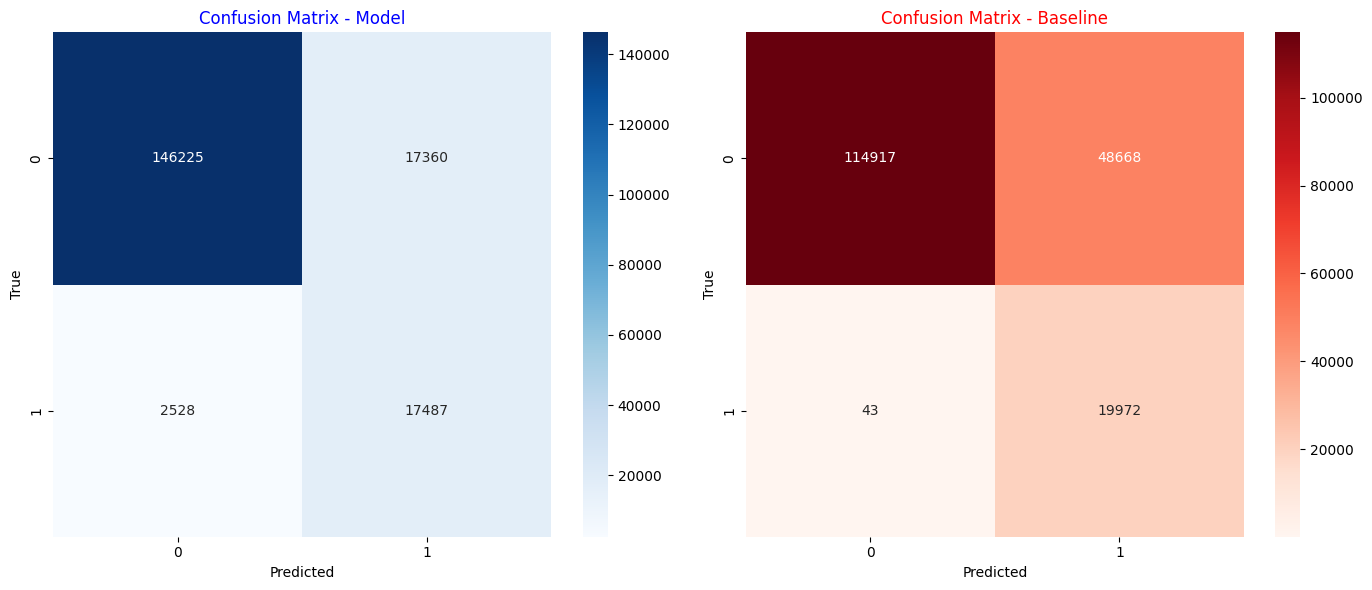

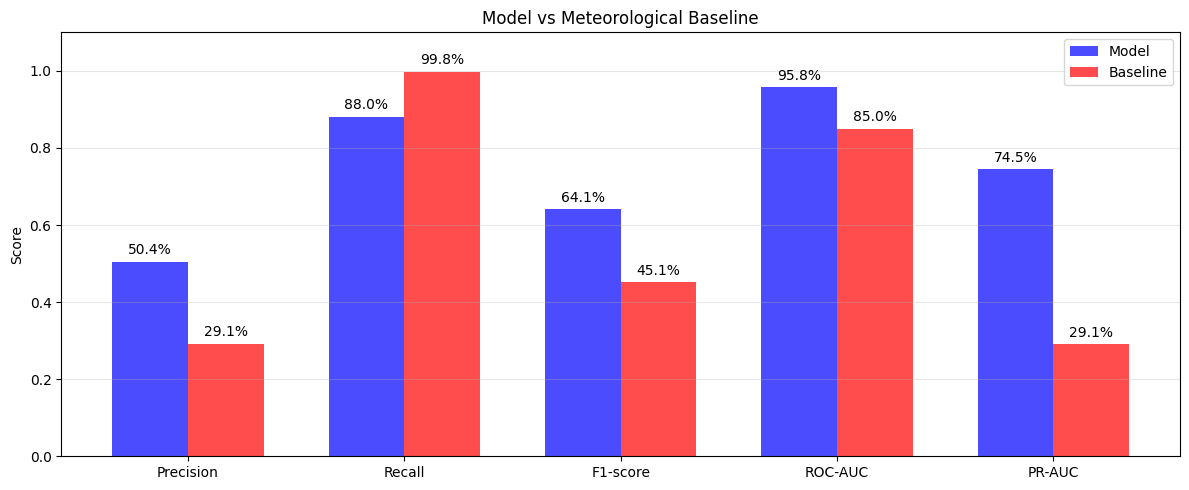

           ROC-AUC    PR-AUC
Model     0.957427  0.744648
Baseline  0.850171  0.290576


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import pandas as pd

# -----------------------------
# 1. Confusion Matrices
# -----------------------------
cm_model = confusion_matrix(y_test, y_pred_model)
cm_base  = confusion_matrix(y_test, y_baseline)

# -----------------------------
# 2. Create a dataframe with metrics for annotation
# -----------------------------
def metrics_df(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df = df[['precision', 'recall', 'f1-score', 'support']]
    return df

metrics_model = metrics_df(y_test, y_pred_model)
metrics_base  = metrics_df(y_test, y_baseline)

# -----------------------------
# 3. Plot Confusion Matrices (mit passenden Farben)
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Model → Blau
sns.heatmap(cm_model, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=True)
axes[0].set_title('Confusion Matrix - Model', color='blue')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Baseline → Rot/Orange
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Reds', ax=axes[1], cbar=True)
axes[1].set_title('Confusion Matrix - Baseline', color='red')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

# -----------------------------
# 4. Plot Metrics (Precision, Recall, F1)
# -----------------------------
import matplotlib.pyplot as plt
import numpy as np

# Metriken vorbereiten
metrics_names = ['Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']
model_scores    = [0.504, 0.880, 0.641, 0.957617, 0.744639]
baseline_scores = [0.291, 0.998, 0.451, 0.850171, 0.290576]

x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, model_scores, width, label='Model', color='blue', alpha=0.7)
plt.bar(x + width/2, baseline_scores, width, label='Baseline', color='red', alpha=0.7)

# Prozentzahlen über Balken
for i in range(len(x)):
    plt.text(x[i] - width/2, model_scores[i]+0.02, f"{model_scores[i]*100:.1f}%", ha='center')
    plt.text(x[i] + width/2, baseline_scores[i]+0.02, f"{baseline_scores[i]*100:.1f}%", ha='center')

plt.xticks(x, metrics_names)
plt.ylim(0,1.1)
plt.ylabel('Score')
plt.title('Model vs Meteorological Baseline')
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
# -----------------------------
# 5. ROC-AUC & PR-AUC Comparison
# -----------------------------
roc_model = roc_auc_score(y_test, y_proba_model)
pr_model  = average_precision_score(y_test, y_proba_model)

roc_base  = roc_auc_score(y_test, y_baseline)
pr_base   = average_precision_score(y_test, y_baseline)

metrics_summary = pd.DataFrame({
    'ROC-AUC': [roc_model, roc_base],
    'PR-AUC' : [pr_model, pr_base]
}, index=['Model', 'Baseline'])

print(metrics_summary)

In [23]:
!pip install shap --break-system-packages

False positive (FP): 17360
Right negative (TN): 146225

Top 15 differences FP vs TN:
                      Mean_FP  Mean_TN  Difference  SHAP_FP  SHAP_TN
heat_aridity_index    -43.279  -57.201      13.922    0.017    0.041
shortwave_radiation   230.578  240.479      -9.901    0.073    0.086
t_850hPa              291.069  284.032       7.037    1.293    2.344
relative_humidity_2m   61.198   68.083      -6.886    0.025    0.027
temperature_2m         24.387   19.156       5.231    0.157    0.110
lag_t850_72h          289.288  284.465       4.823    0.256    0.265
t_500hPa              263.212  259.359       3.853    0.103    0.361
lag_t500_48h          263.044  259.271       3.773    0.031    0.092
lag_t500_72h          262.876  259.264       3.611    0.034    0.053
wind_speed_10m          9.963   12.186      -2.223    0.049    0.073
delta_hum_24h          -1.445    0.326      -1.771    0.083    0.070
v_500hPa                0.748   -0.550       1.298    0.076    0.073
v_850hPa          

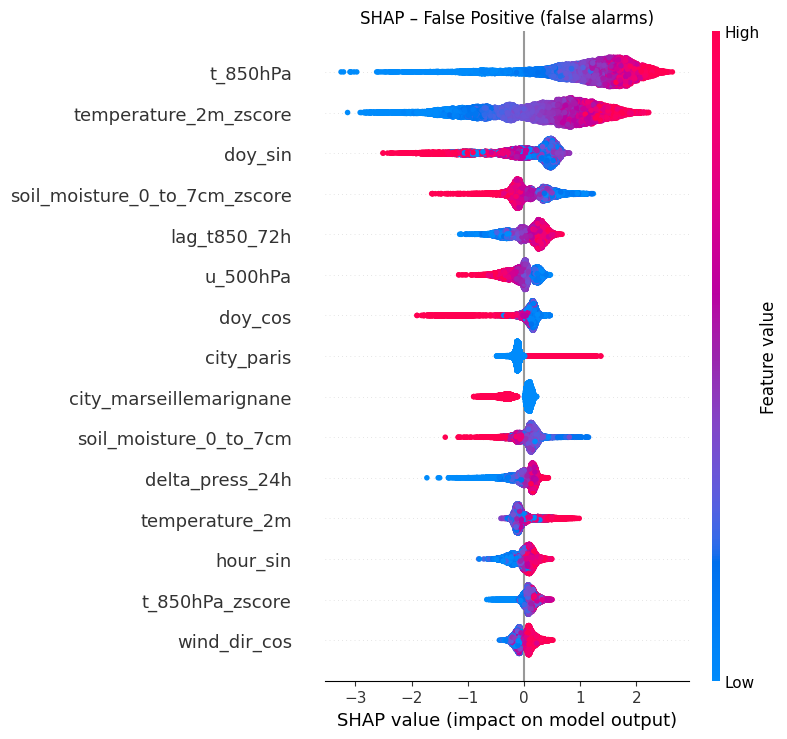

In [25]:
################################################################################
# SHAP: WHY FALSE POSITIVES?
################################################################################

import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# False positives: Model says 1, truth is 0
fp_mask = (y_test == 0) & (y_pred_model == 1)
tn_mask = (y_test == 0) & (y_pred_model == 0)

print(f"False positive (FP): {fp_mask.sum()}")
print(f"Right negative (TN): {tn_mask.sum()}")

# SHAP values for FP vs TN (True negatives)
shap_fp = shap_values[fp_mask.values]
shap_tn = shap_values[tn_mask.values]

X_fp = X_test[fp_mask]
X_tn = X_test[tn_mask]

################################################################################
# FEATURE AVERAGES: FP vs TN
################################################################################

feature_diff = pd.DataFrame({
    'Mean_FP':    X_fp.mean(),
    'Mean_TN':    X_tn.mean(),
    'Difference':  X_fp.mean() - X_tn.mean(),
    'SHAP_FP':    np.abs(shap_fp).mean(axis=0),
    'SHAP_TN':    np.abs(shap_tn).mean(axis=0),
}).sort_values('Difference', key=abs, ascending=False)

print("\nTop 15 differences FP vs TN:")
print("="*70)
print(feature_diff.head(15).round(3))

################################################################################
# SUMMARY PLOT ONLY FALSE POSITIVE
################################################################################

plt.figure()
shap.summary_plot(
    shap_fp,
    X_fp,
    max_display=15,
    show=False,
)
plt.title("SHAP – False Positive (false alarms)")
plt.tight_layout()
plt.savefig("shap_fp.png", dpi=150, bbox_inches='tight')
plt.show()

In [26]:
################################################################################
# SHAP ANALYSIS: RELEVANT VALUES AS A TABLE
################################################################################

import pandas as pd
import numpy as np

# 1. AVERAGE ABSOLUTE SHAP VALUES (Feature Importance)
shap_importance = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=feature_cols
).sort_values(ascending=False)

# 2. AVERAGE SHAP VALUES (direction of the effect)
shap_mean = pd.Series(
    shap_values.mean(axis=0),
    index=feature_cols
)

# 3. THRESHOLD VALUE: where does SHAP change from negative to positive?
def estimate_threshold(feature, shap_vals, X):
    feat_vals = X[feature].values
    s_vals    = shap_vals[:, X.columns.get_loc(feature)]
    idx = np.argsort(feat_vals)
    feat_sorted = feat_vals[idx]
    shap_sorted = s_vals[idx]
    sign_changes = np.where(np.diff(np.sign(shap_sorted)))[0]
    if len(sign_changes) > 0:
        return feat_sorted[sign_changes[0]]
    return np.nan

# 4. COMPILE TABLE
top_n = 20
top_features = shap_importance.head(top_n).index.tolist()

rows = []
for feat in top_features:
    rows.append({
        'Feature':              feat,
        'SHAP Importance':      round(float(shap_importance[feat]), 4),
        'SHAP direction (mean)': round(float(shap_mean[feat]), 4),
        'Effect':               '↑ heat event' if shap_mean[feat] > 0 else '↓ no event',
        'Threshold':        round(float(estimate_threshold(feat, shap_values, X_test)), 3),
        'Feature Mean':         round(float(X_test[feat].mean()), 3),
        'Feature Std':          round(float(X_test[feat].std()), 3),
    })

shap_table = pd.DataFrame(rows)

pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.4f}'.format)

print("="*120)
print("SHAP ANALYSIS: TOP 20 FEATURES")
print("="*120)
shap_table

SHAP ANALYSIS: TOP 20 FEATURES


,Feature,SHAP Importance,SHAP direction (mean),Effect,Threshold,Feature Mean,Feature Std
0,t_850hPa,2.1385,-1.3775,↓ no event,286.7750,285.5360,5.0990
1,temperature_2m_zscore,1.1421,-0.6657,↓ no event,0.5600,0.2200,1.0970
2,doy_sin,0.8654,-0.6667,↓ no event,-0.8260,-0.1850,0.6210
3,doy_cos,0.4104,-0.2864,↓ no event,-1.0000,-0.7110,0.2730
4,soil_moisture_0_to_7cm_zscore,0.3241,-0.0754,↓ no event,-4.3240,-0.4680,1.3180
5,t_500hPa,0.3083,-0.1936,↓ no event,259.6930,260.1510,4.0370
6,soil_moisture_0_to_7cm,0.2936,-0.1616,↓ no event,0.0100,0.2050,0.0860
7,t_850hPa_zscore,0.2738,-0.1731,↓ no event,-0.0330,0.3210,1.0420
8,lag_t850_72h,0.2637,-0.1208,↓ no event,272.3450,285.4410,5.1920
9,city_paris,0.1909,-0.0584,↓ no event,0.0000,0.2000,0.4000
